In [1]:
import ROOT
import uproot
import awkward as ak
import numpy as np
from hist import Hist
from numba import njit

Loading CENNSMC Root Utilities
Welcome to JupyROOT 6.28/04


In [2]:
@njit
def generate_f90(pes, m, pe_centers, f90_edges):
    i = np.argmin(np.abs(pe_centers - pes))
    w = m[i] / m[i].sum()
    cdf = np.cumsum(w)
    r = np.random.rand()
    bin_index = np.searchsorted(cdf, r)
    random_value = np.random.uniform(f90_edges[bin_index], f90_edges[bin_index + 1])
    
    return random_value

In [3]:
with uproot.open("../data/PDF_noWaterData.root") as f:
    nowater = f['PDFTree']
    ens = nowater['energy'].array()
    f90s = nowater['F90'].array()
    h_f90 = Hist.new.Reg(500, 0, 1000).Reg(50, 0, 1).Double()
    h_f90.fill(ens * 4.5, f90s)
    m = h_f90.values()
    pe_centers = h_f90.axes[0].centers
    f90_edges = h_f90.axes[1].edges
    generate_f90(10, m, pe_centers, f90_edges)

In [4]:
def ss_rates(data, h1, h2):
    rng = np.random.default_rng(1234)
    for batch in uproot.iterate(data, step_size="100 MB", filter_name='fv*f[DS]*'):
        pos = batch['fvChannels.fSensorPosition']
        pmt_photons = batch['fvChannels.fDetPhotonsTot']
        events = ak.num(pos, axis=1) > 0
        top_pmts = pos[events][..., 2] > 0
        bot_pmts = pos[events][..., 2] < 0
        bot_photons = ak.sum(pmt_photons[events][bot_pmts], axis=-1)
        top_photons = ak.sum(pmt_photons[events][top_pmts], axis=-1)
        quality_cut = (top_photons >= 2) & (bot_photons >= 2)
        det_photons = (top_photons + bot_photons)[quality_cut]
        smeared_photons = rng.normal(det_photons, 0.44 * np.sqrt(det_photons))
        f90s = np.array([generate_f90(smeared_photon, m, pe_centers, f90_edges) for smeared_photon in smeared_photons])
        f90_cut = (f90s > 0.5) & (f90s < 0.9)
        reco_energies = smeared_photons * 0.1658450956443337
        w = ak.ones_like(reco_energies)
        reco_energies_f90 = smeared_photons[f90_cut] * 0.1658450956443337
        w_f90 = ak.ones_like(reco_energies_f90)
        h1.FillN(len(smeared_photons), ak.to_numpy(reco_energies), ak.to_numpy(w))
        h2.FillN(len(reco_energies_f90), ak.to_numpy(reco_energies_f90), ak.to_numpy(w_f90))

In [5]:
h_f90 = ROOT.TH1D("h_f90", "Background sim;Det. photons;Counts", 40, 0, 40)
h = ROOT.TH1D("h", "Background sim;Det. photons;Counts", 40, 0, 40)
data = ["/N/u/bojohn/Quartz/slate/5691721/test_*", "/N/u/bojohn/Quartz/slate/5691725/test_*", "/N/u/bojohn/Quartz/slate/5691726/test_*"]
ss_rates(data, h, h_f90)

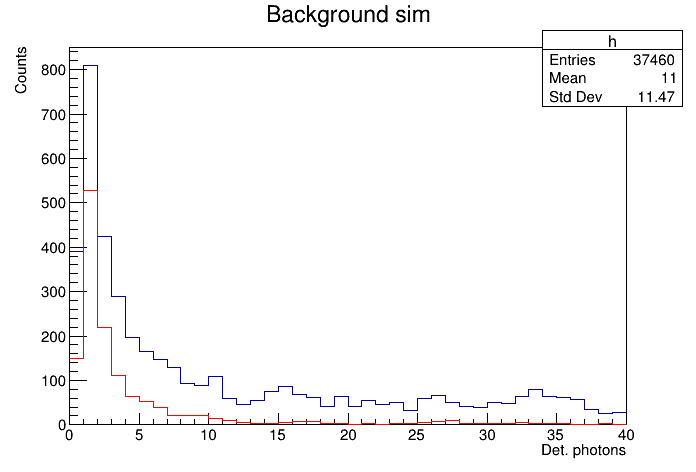

In [6]:
c = ROOT.TCanvas()
h.Draw()
h_f90.SetLineColor(ROOT.kRed)
h_f90.Draw('same')
c.Draw()

In [7]:
full_rate = h.Integral(6, 39)
f90_rate = h_f90.Integral(6, 39)
print(full_rate)
print(f90_rate)
print(full_rate / f90_rate)
fout = ROOT.TFile("../data/pb210_morestats.root", "recreate")
h.Write()
h_f90.Write()
fout.Close()

2254.0
277.0
8.137184115523466


In [14]:
h_hogf90 = ROOT.TH1D("hog_phase1", "Background sim;Det. photons;Counts", 40, 0, 40)
h_hog = ROOT.TH1D("hog_phase1nof90", "Background sim;Det. photons;Counts", 40, 0, 40)
data = ["/N/u/bojohn/Quartz/slate/5486079/test_*"]
ss_rates(data, h_hog, h_hogf90)

Warning in <TROOT::Append>: Replacing existing TH1: hog_phase1 (Potential memory leak).


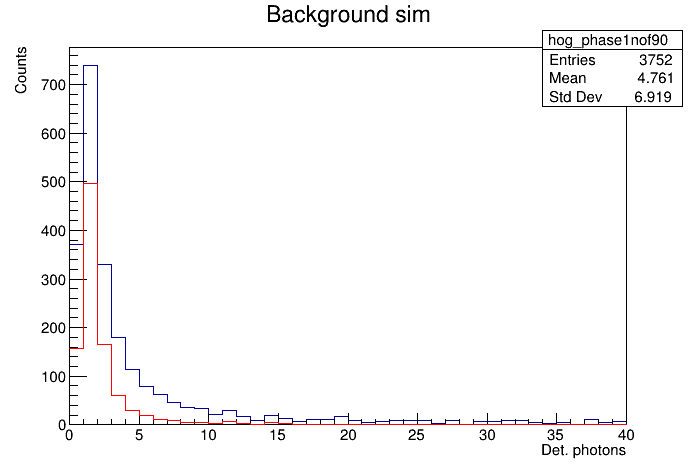

In [15]:
c = ROOT.TCanvas()
h_hog.Draw()
h_hogf90.SetLineColor(ROOT.kRed)
h_hogf90.Draw('same')
c.Draw()

In [16]:
full_rate = h_hog.Integral(6, 39)
f90_rate = h_hogf90.Integral(6, 39)
print(full_rate)
print(f90_rate)
print(full_rate / f90_rate)
fout = ROOT.TFile("../data/hog_phase1.root", "recreate")
h_hog.Write()
h_hogf90.Write()
fout.Close()

527.0
75.0
7.026666666666666
